<a href="https://colab.research.google.com/github/bmercer486/tam470-tutorials/blob/main/rk4_lf_ab2_bdf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear pendulum simulation

## The ODE

When a pendulum has small-amplitude swings, the ODE for its motion is
$\theta''(t) = -\omega^2\theta(t)$,

Since it's a 2nd order ODE, we'll transform this into a system of two first order ODEs as follows

$$y_1 = \theta(t), \quad y_2 = \theta'(t)$$

$$\rightarrow \mathbf{y} = \left[\array{y_1 \\ y_2}\right] = \left[\array{\theta \\ \theta'}\right]$$

Then

$$\mathbf{y}' = \left[\array{0 & 1 \\ -\omega^2 & 0}\right]\left[\array{y_1 \\ y_2}\right]$$

The eigenvalues for this system correspond to the natural frequency of the pendulum, $\lambda_{1,2} = \pm i\omega$.

## Numerical solution

The code below solves this problem using RK4, AB2, Leapfrog and BDF2 schemes

The multistep schemes require a startup time step. Since RK4 is self-starting and is computed first anyways, each scheme uses the RK4 result to advance the first step before switching to its own multistep update rule.

In [61]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Constants
w = 4 # Frequency parameter

# f(y) for the pendulum system
A = np.array([[0, 1],[-w**2, 0]])
f = lambda y: A@y

# Initial conditions and time step setup
y0 = np.array([1, 0])
h = .1
T = 6
N = round(T/h)
t = np.linspace(0, T, N+1)

# Set up solution vectors for each of the methods
yrk4  = np.zeros((2,N+1))
ylf   = np.zeros((2,N+1))
yab2  = np.zeros((2,N+1))
ybdf2 = np.zeros((2,N+1))

# Set initial conditions
yrk4[:,0]  = y0
ylf[:,0]   = y0
yab2[:,0]  = y0
ybdf2[:,0] = y0

# Time step loop - takes N steps
for n in range(N):

    # RK4 update
    k1 = f(yrk4[:,n])
    k2 = f(yrk4[:,n] + 0.5*h*k1)
    k3 = f(yrk4[:,n] + 0.5*h*k2)
    k4 = f(yrk4[:,n] + h*k3)
    yrk4[:,n+1] = yrk4[:,n] + h*(k1/6 + k2/3 + k3/3 + k4/6)

    # Multistep schemes: Each requires a different method to start up
    if(n==0):

        # Use the RK4 result since we have it already
        ylf[:,n+1]   = yrk4[:,n+1]
        yab2[:,n+1]  = yrk4[:,n+1]
        ybdf2[:,n+1] = yrk4[:,n+1]

    # Use the appropriate scheme for the 2nd step onwards
    else:
        # Leapfrog update
        ylf[:,n+1] = ylf[:,n-1] + 2*h*f(ylf[:,n])
        # AB2 update
        yab2[:,n+1] = yab2[:,n] + 1.5*h*f(yab2[:,n]) - 0.5*h*f(yab2[:,n-1])
        # BDF2 update
        ybdf2[:,n+1] = np.linalg.solve(np.eye(2) - (2/3)*h*A, (4/3)*ybdf2[:,n] - (1/3)*ybdf2[:,n-1])


# Print time step used and critical time step for stability for the explicit schemes
print('h                   = ', h)
print('h_critical RK4      = ', 2.83/w)
print('h_critical Leapfrog = ', 1/w)
print('h_critical AB2      = ', 0)


h                   =  0.1
h_critical RK4      =  0.7075
h_critical Leapfrog =  0.25
h_critical AB2      =  0


## Plotting

We examine plots of each method versus the true solution.

Try running the code for different time steps and think about the following questions:
1. Which schemes are stable? Conditionally stable? Unstable?
2. What differences do you see in amplitude (peak height) and phase shift (peak position) for each scheme?

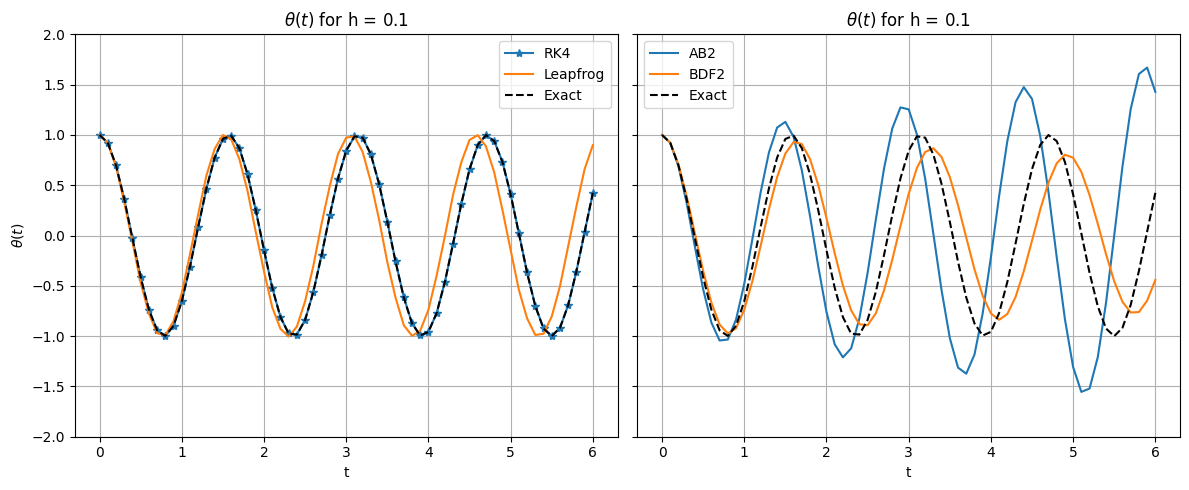

In [62]:
# True solution
theta_true = y0[0]*np.cos(t*w)

# Set up two side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left: RK4 vs Leapfrog
axs[0].plot(t, yrk4[0, :], '*-', label='RK4')
axs[0].plot(t, ylf[0, :], label='Leapfrog')
axs[0].plot(t, theta_true, 'k--', label='Exact')
axs[0].grid()
axs[0].set_xlabel('t')
axs[0].set_ylabel(r'$\theta(t)$')
axs[0].set_title(r'$\theta(t)$ for h = ' + str(h))
axs[0].set_ylim(-2, 2)
axs[0].legend()

# Right: AB2 vs BDF2
axs[1].plot(t, yab2[0, :], label='AB2')
axs[1].plot(t, ybdf2[0, :], label='BDF2')
axs[1].plot(t, theta_true, 'k--', label='Exact')
axs[1].grid()
axs[1].set_xlabel('t')
axs[1].set_title(r'$\theta(t)$ for h = ' + str(h))
axs[0].set_ylim(-2, 2)
axs[1].legend()

plt.tight_layout()